# **Neccesary Imports**

> This section just imports all the neccesary packages

In [3]:
import numpy as np
import itertools
import pandas as pd
import os
import math
import random
import cv2
import sys
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.activations import swish
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from imgaug import augmenters as iaa
from tqdm.notebook import tqdm

# **Global Variables**

> In this section, we'll define some neccessary variables like paths and images sizes.

---

* This is done at the beginning so that they can be used and re-used later all throughout the notebook.

* Another reason for this is so that the notebook can easily be ported to a script later on.

---

In [4]:
# Set some global variables
train_dir = "../input/plant-seedlings-classification/train/"
test_dir = "../input/plant-seedlings-classification/test/"
save_dir = "/kaggle/working/plant-seedlings-classification/train"
target_size = (224, 224)

# **1. Understanding the Dataset Distribution**

> In this section, primarily, we will look at the **class distributions.**

---

* Knowing whether there are imbalances in the data, can help us take proper precautions during training.
* And by taking proper precautions, we can make sure the model does not only learn the over-represented data. 

---

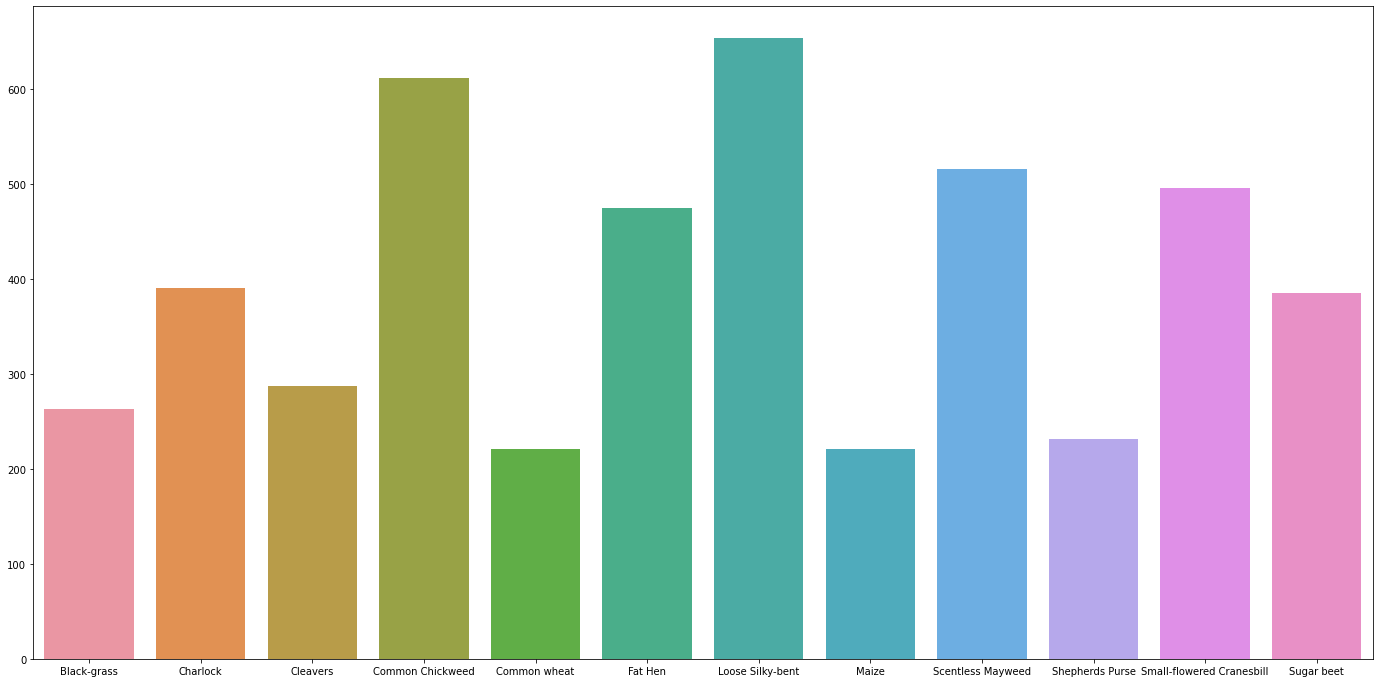

In [5]:
# Get names of all the categories 
categories = [category for category in sorted(os.listdir(train_dir))]

# Get the number of images in each cateogry
images_per_category = [len(os.listdir(os.path.join(train_dir, category))) for category in categories]

# Plot to see the distribution
plt.figure(figsize=(24,12))
sns.barplot(categories, images_per_category)

## **Conclusions**

---

* Clearly, there is **class imbalance.**

* The **lowest number of images (for a class) is 221** and the **highest number of images (for a class) is 654**

* Although the **scale of imbalance is not very severe**, and **deep learning models are fairly robust** to such less-severe imbalances, we will still **use augmentation to balance the classes** and see what happens.

---

# **2. Defining the DataLoader and Utilities Classes**

> **In this section we'll be defining two Classes (`DataLoader` and `Utilities`) that will abstract away the notebook logic into two parts.** 

> **This leaves us with a clean implementation which is easy to follow, modify and debug.**

---

* `DataLoader` -> Builds a clean interface to handle all the preprocessing, balancing and loading of the dataset for visualization or training.

* `Utilities`  -> Allows easy plotting of graphs and summarizing models after training them. 

* We will instantiate objects of both classes at the end of this section, so that they are ready to use later. 

* We will also visualize the effect of preprocessing by calling the `show_sample_images()` method

---

In [6]:
class DataLoader():
    """
    Args:
    train_dir -- points to the training directory
    test_dir -- points to the test directory
    save_dir -- points to the path where augmented data should be stored
    segmentation -- determines whether to apply segmentation during preprocessing or not
    target_size -- the size to which each image in the dataset should be resized
    
    Returns:
    An instance of itself
    """
    
    def __init__(self, **kwargs):
        
        self.train_dir = kwargs.get('train_dir')
        self.test_dir = kwargs.get('test_dir')
        self.save_dir = kwargs.get('save_dir')
        self.segmentation = kwargs.get('segmentation')
        self.target_size = kwargs.get('target_size')
        categories = [category for category in sorted(os.listdir(self.train_dir))]
        self.data_og = [self.preprocessing_pipeline(os.path.join(self.train_dir, category, img_path)) for category in categories for img_path in os.listdir(os.path.join(self.train_dir, category))]
        if self.segmentation:
            self.data_seg = [self.segmentation_pipeline(self.preprocessing_pipeline(os.path.join(self.train_dir, category, img_path))) for category in categories for img_path in os.listdir(os.path.join(self.train_dir, category))]
            
        try:
            assert self.train_dir
            assert self.test_dir
            assert self.save_dir
        except (AssertionError, NameError):
            sys.exit("Call to this should class must have at least 1. train_dir,  2. test_dir, 3. save_dir")
        
        
    # Helper Function 1
    # Create a binary mask for a given HSV range
    def create_mask_for_plant(self, image):
        image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        lower_hsv = np.array([25, 50, 50])
        upper_hsv = np.array([95, 255, 255])
        mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        return mask

    # Helper Function 2
    # Use the binary mask to segment the image
    def segment_plant(self, image):
        mask = self.create_mask_for_plant(image)
        output = cv2.bitwise_and(image, image, mask = mask)
        return output

    # Helper Function 3
    # Sharpen the segmented image for contrast
    def sharpen_image(self, image):
        #image_median_blurred = cv2.medianBlur(image, 3)
        image_sharp = cv2.bilateralFilter(image, 11, 11, 11) 
        #image_blurred = cv2.GaussianBlur(image_median_blurred, (0, 0), 3)
        #image_sharp = cv2.addWeighted(image, 1.5, image_median_blurred, -0.5, 0)
        return image_sharp

    # Helper Function 4 
    # Augment passed images
    def augment_images(self, class_images):
        seq = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Flipud(0.5),
            iaa.Affine(rotate=(-45, 45)),
            iaa.TranslateX(percent=(-0.1, 0.1)),
            iaa.TranslateY(percent=(-0.1, 0.1))
        ], random_order=True)

        images_aug = seq(images = class_images)
        return images_aug

    # Helper Function 5
    # Randomly sample images from a set of passed images
    def random_unique_sampling(self, class_images, remainder):
        random_unique_indices = random.sample(range(0, len(class_images)), remainder)
        random_unique_images = [class_images[idx] for idx in random_unique_indices]
        return random_unique_images
        

    def augmentation_pipeline(self, class_images, number_of_images):
        """Accepts a batch of images (of a single class) and returns a required number of augmented images"""

        if number_of_images == 0:
                return []

        elif number_of_images >= len(class_images):
            batches = math.floor(number_of_images / len(class_images))
            remainder = number_of_images % len(class_images)
            remainder_images = self.random_unique_sampling(class_images, remainder)
            class_images = class_images * batches
            class_images.extend(remainder_images)
            images_aug = self.augment_images(class_images)
            return images_aug

        else:
            assert number_of_images < len(class_images)
            class_images = self.random_unique_sampling(class_images, number_of_images)
            images_aug = self.augment_images(class_images)
            return images_aug
        
    def preprocessing_pipeline(self, path):
        """Accepts a path and returns a processed image involving reading and resizing"""
        image = cv2.resize(cv2.imread(path), self.target_size, interpolation = cv2.INTER_NEAREST)
        return image


    def segmentation_pipeline(self, image):
        """Accepts an image and returns a HSV segmented version of the image"""
        image_segmented = self.segment_plant(image)
        image_sharpen = self.sharpen_image(image_segmented)
        return image_sharpen
    
    
    def balance_dataset(self):
        """Create augmented data to balance classes from the passed training data path"""
        
        # Make a directory for augmented dataset
        os.makedirs(self.save_dir, exist_ok=True)
        
        # Get categories
        categories = [category for category in sorted(os.listdir(self.train_dir))]

        # Get the maximum amount of images that exists in a class
        max_in_class = max([len(os.listdir(os.path.join(self.train_dir, category))) for category in categories])

        # Find out the augmentations required for each class
        images_per_category = {category : len(os.listdir(os.path.join(self.train_dir, category))) for category in categories}

        # Find out the augmentations required for each class
        required_augmentations = dict(zip(categories,  [max_in_class - num_in_class for num_in_class in list(images_per_category.values())]))

        # Augment each unbalanced class and save the new dataset to disk
        # We preferring saving the data to disk
        # Because we prefer to not hold large numpy arrays in the RAM
        # This allows for large models to be loaded and trained on
        # We use for loops here instead of list comprehensions for readiblity
        for category in tqdm(categories):
            try:
                os.mkdir(os.path.join(self.save_dir, category))
            except FileExistsError:
                pass
            class_images = list()

            # Preprocessing and Augmentation
            for img_path in sorted(os.listdir(os.path.join(self.train_dir, category))):
                image = self.preprocessing_pipeline(os.path.join(self.train_dir, category, img_path))
                if self.segmentation == True:
                    image = self.segmentation_pipeline(image)
                class_images.append(image)
            augmented_images = self.augmentation_pipeline(class_images, required_augmentations[category])
            class_images.extend(augmented_images)

            # Writing the augmented data to disk
            for image_number, class_image in enumerate(class_images):
                cv2.imwrite(os.path.join(self.save_dir, category, "{}.png".format(image_number + 1)), class_image)
        
    def load_for_train(self, model):
        
        if model == "resnet50":
            datagen = ImageDataGenerator(preprocessing_function = resnet50.preprocess_input, validation_split=0.15)
            target_size = (224, 224)
        elif model == "inception_v3":
            datagen = ImageDataGenerator(preprocessing_function = inception_v3.preprocess_input, validation_split=0.15)
            target_size = (299, 299)
        elif model == 'vgg16':
            datagen = ImageDataGenerator(preprocessing_function = vgg16.preprocess_input, validation_split=0.15)
            target_size = (224, 224)
        else:
            sys.exit('Fatal Error: Invalid Model Requested.')


        train_generator = datagen.flow_from_directory(
                directory= os.path.join(self.save_dir),
                target_size= target_size,
                class_mode = "categorical",
                batch_size=32,
                shuffle=True,
                subset='training'
            )
        
        val_generator = datagen.flow_from_directory(
                directory= os.path.join(self.save_dir),
                target_size= target_size,
                class_mode = 'categorical',
                batch_size=32,
                shuffle=False,
                subset='validation'
            )

        return train_generator, val_generator
        
    def load_for_viz(self, model):
        
        if model == "resnet50":
            datagen = ImageDataGenerator(preprocessing_function = resnet50.preprocess_input, validation_split=0.15)
            target_size = (224, 224)
        elif model == "inception_v3":
            datagen = ImageDataGenerator(preprocessing_function = inception_v3.preprocess_input, validation_split=0.15)
            target_size = (299, 299)
        elif model == 'vgg16':
            datagen = ImageDataGenerator(preprocessing_function = vgg16.preprocess_input, validation_split=0.15)
            target_size = (224, 224)
        else:
            sys.exit('Fatal Error: Invalid Model Requested.')

        generator = datagen.flow_from_directory(
        directory= os.path.join(self.save_dir),
        target_size= target_size,
        batch_size=1,
        class_mode=None,
        shuffle=False
        )
        
        categories = [category for category in sorted(os.listdir(self.train_dir))]
        max_in_class = max([len(os.listdir(os.path.join(self.train_dir, category))) for category in categories])
        categories_rep = list(itertools.chain.from_iterable(itertools.repeat(x, max_in_class) for x in categories))
        data_df = pd.DataFrame(categories_rep, columns = ["categories"])
        
        return generator, data_df
    
    def show_sample_images(self):
        categories = [category for category in sorted(os.listdir(self.train_dir))]
        random_indices = random.sample(range(0, len(self.data_og)), 4)
        
        # Plot some sample images from the dataset
        _, axs = plt.subplots(1, 4, figsize=(20, 20))
        for i in range(4):
            axs[i].imshow(self.data_og[random_indices[i]])
        
        # Plot segmented images if segmentation is True
        if self.segmentation:
            _, axs = plt.subplots(1, 4, figsize=(20, 20))
            for i in range(4):
                axs[i].imshow(self.data_seg[random_indices[i]])
            

In [7]:
class Utilities:
    """
    Boilerplate code that can be re-used multiple times to plot training graphs, visualization plots, training summary.
    
    Args:
    train_dir -- points to the training directory
    
    Returns:
    An instance of itself
    """
    
    def __init__(self, train_dir, save_dir):
        self.train_dir = train_dir
        self.save_dir = save_dir
        
        
    def plot_tSNE(self, data_df, base_model, generator, title):
        
        feature_vector = base_model.predict_generator(generator, 7848, verbose =1)
        print('Extratced feature dimensionality: {}'.format(feature_vector.shape))
        tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
        tsne_results = tsne.fit_transform(feature_vector)
        
        data_df['tsne-2d-one'] = tsne_results[:,0]
        data_df['tsne-2d-two'] = tsne_results[:,1]

        plt.figure(figsize=(20,16))
        plt.title("tSNE Visualization - " + title)
        sns.scatterplot(
            x="tsne-2d-one", y="tsne-2d-two",
            hue="categories",
            palette=sns.color_palette("hls", 12),
            data=data_df,
            legend="full",
            alpha=0.3
        )
        plt.savefig(os.path.join(os.path.normpath(self.save_dir + os.sep + os.pardir), title + ".png"), dip=300, bbox_inches='tight')
        
    def summarize_model(self, history_model, model, val_generator):
        categories = [category for category in sorted(os.listdir(self.train_dir))]
        self.plot_curves(history_model)
        self.plot_classification_metrics(categories, model, val_generator)


    def plot_curves(self, history_model):
        plt.style.use('seaborn')

        # Summarize history for accuracy
        plt.figure(1, figsize=(16, 10))
        plt.plot(history_model.history['accuracy'])
        plt.plot(history_model.history['val_accuracy'])
        plt.title('Train and Validation Accuracy', fontsize = 16)
        plt.ylabel('Accuracy', fontsize = 14)
        plt.xlabel('Epoch', fontsize = 14)
        plt.legend(['Train', 'Validation'], fontsize = 14)
        plt.show()

        # Summarize history for loss
        plt.figure(2, figsize=(16, 10))
        plt.plot(history_model.history['loss'])
        plt.plot(history_model.history['val_loss'])
        plt.title('Train and Validation Loss', fontsize = 16)
        plt.ylabel('Loss', fontsize = 14)
        plt.xlabel('Epoch', fontsize = 14)
        plt.legend(['Train', 'Validation'], fontsize = 14)
        plt.show()

    def plot_classification_metrics(self, categories, model, val_generator):

        predictiions = model.predict_generator(val_generator, 48)
        y_pred = np.argmax(predictiions, axis=1)
        cf_matrix = confusion_matrix(val_generator.classes, y_pred)
        print('Classification Report')
        print(classification_report(val_generator.classes, y_pred, target_names=categories))
        plt.figure(figsize=(20,20))
        sns.heatmap(cf_matrix, annot=True, xticklabels=categories, yticklabels=categories, cmap='Blues')

In [8]:
# Instantiate objects of both the classes
# We will then use the methods of these two classes to handle various tasks

# Initialize DataLoader
dataloader = DataLoader(train_dir = train_dir, test_dir = test_dir, save_dir = save_dir, target_size = target_size, segmentation = True)

# Initialize Utilities
utils = Utilities(train_dir, save_dir)

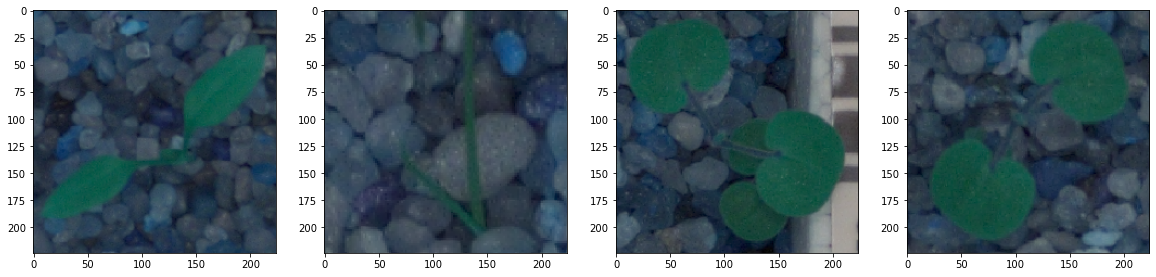

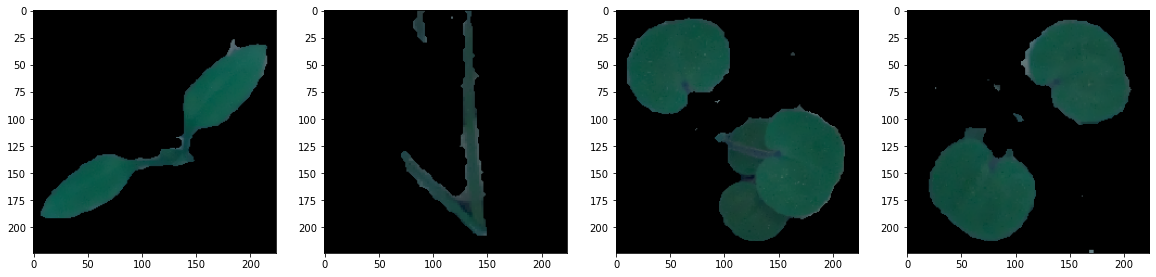

In [9]:
# We can also check out some images of the dataset we have generated
dataloader.show_sample_images()

# 3. Balancing the Dataset using DataLoader

> This section deals with balancing the dataset using data augmentation.

---

* The goal is to balance the dataset such that each class has as many images as any. 

* This means, we will augment each class to match 654 images of the maximum class (Loose-silky Bent)

* This can be handled by calling the `balance_dataset()` method of `DataLoader` 

---


In [10]:
# Balance the dataset
dataloader.balance_dataset()

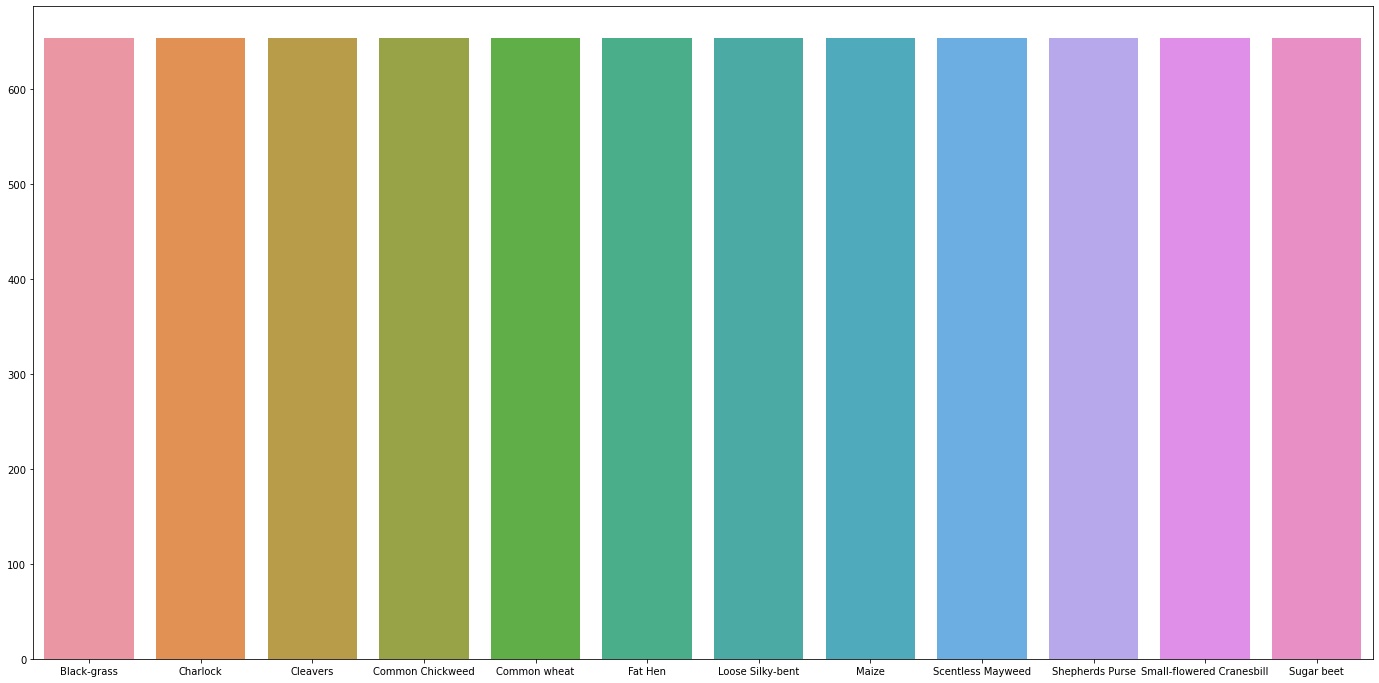

In [11]:
# We can confirm that the dataset was balanced

# Get names of all the categories 
categories = [category for category in sorted(os.listdir(save_dir))]

# Get the number of images in each cateogry
images_per_category = [len(os.listdir(os.path.join(save_dir, category))) for category in categories]

# Plot to see the distribution
plt.figure(figsize=(24,12))
sns.barplot(categories, images_per_category)

## Conclusion

> We can verify that the dataset is now balanced!

---

# 4. Combining Dimensionality Reduction and Visualization. 

> In this section we'll visualize the datset by using pretrained models as feature extractors

---

* Visualization is important because it allows us to determine the seperability of the classes that we have. 

* It gives us an intuition as to how easy or difficult the classification problem will be. 

* In fact, we can go a step further by using pretrained models as feature extractos and then compare if one model can achieve better seperability than the other.

* We will use VGG, ResNet50 and InceptionV3 for our visualizations. 
---

## a.   Visualization using InceptionV3

# Load a generator for the data using the DataLoader Class
generator, data_df = dataloader.load_for_viz(model = "inception_v3")

# Define the InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg', input_shape=(299, 299, 3))

# Plot a tSNE visualization using InceptionV3 as feature extractor using Utilities
utils.plot_tSNE(data_df, base_model, generator, title = 'Inception v3')

## b.   Visualization using VGG16

# Load a generator for the data using the DataLoader Class
generator, data_df = dataloader.load_for_viz(model = "vgg16")

# Define the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))

# Plot a tSNE visualization using VGG16 as feature extractor
utils.plot_tSNE(data_df, base_model, generator, title = 'VGG16')

## c.   Visualization using ResNet50

# Load a generator for the data using the DataLoader Class
generator, data_df = dataloader.load_for_viz(model = "resnet50")

# Define the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))

# Plot a tSNE visualization using ResNet50 as feature extractor
utils.plot_tSNE(data_df, base_model, generator, title = 'ResNet50')

## **Conclusions**

* All the three networks manage to give distinct clusters for most classes. 
* In Inception v3, some clusters are very clearly diffrentiable but others are somewhat of a mix. 
* VGG16, on the other hand, has more compact and distant clusters than Inception v3.
* ResNet50 too, like VGG16 has compact clusters and we can make a hypothesis here that VGG16 and ResNet50 might outperform the Inception. 
* We may be very well proven wrong since the visualization is done on pretrained weights but after training, the scenario may change. 
* Overall, we can say with reasonable confidence that the dataset can surely be solved with a high degree of accuracy using the pre-trained models. 

# **5. Train Pre-Trained Models**


We will train the following models to see which gives the best validation and test accuracies

* Inception v3
* VGG16
* ResNet50

___

We will follow a standard procedure for training each of the networks in order to evaluate them farily:

* We will unfreeze the approximately 50% of the network as opposed to freezing the entire network. 
* The reason for this is that the models are trained on the ImageNet which has lots of real life backgrounds whereas our dataset has essentially no background due to segmentation. 
* As a result, we need to give the network some space to adapt to the new images.
* As a added advantage, it will also help speed up convergence. 
* We will "slow cook" the network with a very low learning rate so that large updates don't happen and end up destroying the knowledge stored in the weights. 

___


## **1. InceptionV3**

In [ ]:
# Load generators for the data using the DataLoader Class
train_generator, val_generator = dataloader.load_for_train(model = "inception_v3")

# Define callbacks
model_save_path = '/kaggle/working/model_inceptionv3.h5'
checkpoint = ModelCheckpoint(filepath='/kaggle/working/model_inceptionv3.h5', monitor='val_loss', mode='min', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.00000001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='min', restore_best_weights=True)

In [ ]:
# Configure model for transfer learning
base_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg', input_shape=(299, 299, 3))
x = base_model.output
x = Dropout(0.5)(x)
predictions = Dense(12, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

# Freeze the earlier layers
for layer in model.layers[:152]:
    layer.trainable = False
    
    
# Compile the model    
model.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])



# Train the model
history_inception_v3 = model.fit_generator(train_generator,
                      steps_per_epoch = 196,
                      validation_data = val_generator,
                      validation_steps = 48,
                      epochs = 32,
                      verbose = 1,
                      callbacks = [reduce_lr, checkpoint, early_stop])

# Load the best model
model = load_model(model_save_path)
# Summarize the best model
utils.summarize_model(history_inception_v3, model, val_generator)

## **2. VGG16**

In [ ]:
# Load generators for the data using the DataLoader Class
train_generator, val_generator = dataloader.load_for_train(model = "vgg16")

# Define callbacks
model_save_path = '/kaggle/working/model_vgg16.h5'
checkpoint = ModelCheckpoint(filepath=model_save_path, monitor='val_loss', mode='min', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.00000001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min', restore_best_weights=True)

In [ ]:
# Configure model for transfer learning
base_model = VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
x = base_model.output
x = Dropout(0.5)(x)
predictions = Dense(12, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

# Freeze the earlier layers
for layer in model.layers[:-11]:
    layer.trainable = False
    
    
# Compile the model    
model.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])



# Train the model
history_vgg16 = model.fit_generator(train_generator,
                      steps_per_epoch = 196,
                      validation_data = val_generator,
                      validation_steps = 48,
                      epochs = 32,
                      verbose = 1,
                      callbacks = [reduce_lr, checkpoint, early_stop])

# Load the best model
model = load_model(model_save_path)
# Summarize the best model
utils.summarize_model(history_vgg16, model, val_generator)

## **3. ResNet50**

In [ ]:
# Load generators for the data using the DataLoader Class
train_generator, val_generator = dataloader.load_for_train(model = "resnet50")

# Define callbacks
model_save_path = '/kaggle/working/model_resent50.h5'
checkpoint = ModelCheckpoint(filepath=model_save_path, monitor='val_loss', mode='min', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.00000001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min', restore_best_weights=True)

In [ ]:
# Configure model for transfer learning
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
x = base_model.output
x = Dropout(0.5)(x)
predictions = Dense(12, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

# Freeze the earlier layers
for layer in model.layers[:81]:
    layer.trainable = False
    
    
# Compile the model    
model.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])



# Train the model
history_resent50 = model.fit_generator(train_generator,
                      steps_per_epoch = 196,
                      validation_data = val_generator,
                      validation_steps = 48,
                      epochs = 32,
                      verbose = 1,
                      callbacks = [reduce_lr, checkpoint, early_stop])

# Load the best model
model = load_model(model_save_path)
# Summarize the best model
utils.summarize_model(history_resent50, model, val_generator)

# **Conclusion**

___

### On the models:

* Even though all models give out roughly the same validation accuracy (~91%), an important point to note is the misclassifications between Black-grass and Loose Silky-bent. 

* The most "confusion" occurs between Loose Silky-bent and Black-grass for all models as can be seen from the confusion matrix plots as well as the classification reports. 

* However, VGG16 has the least amount of "confusion" between the two classes as evident from the plots and the report. 

* This confirms our initial hypothesis of VGG16 performing the best among all three models. 

* Perhaps this was because VGG16 is a shallower and simpler architecture than the other two which is why the other two ended up overfitting more instead of generalizing. 

* It can also be because VGG16 (as seen in the visualization earlier on) is able to distinctly form compact clusters in the 2D tSNE space.

### On the preprocessing:

* Regarding the segmentation vs a non-segmented approach, we come to the conclusion that an ensemble of the models trained on both kinds of data will achieve better resuls. 

* This inference comes after observing the activations of test images with both models. Some images are better picked up by the segmented approach, and some are better picked up with the non-segmented approach. 

___